#### Import libraries

In [2]:
import torch
from transformers import BertModel, BertTokenizer, utils
import json
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import statistics
import numpy as np
from pydub import AudioSegment

utils.logging.set_verbosity_error()  # Suppress standard warnings


c:\Users\OliverMöller\OneDrive - ondevi GmbH\Dokumente\GitHub\tts-with-prominence-control\tts\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


#### Functions

In [3]:
def init_model(input_str):
  model_version = 'bert-base-uncased'
  model = BertModel.from_pretrained(model_version, output_attentions=True)
  tokenizer = BertTokenizer.from_pretrained(model_version)
  sentence = input_str
  inputs = tokenizer.encode_plus(sentence, return_tensors='pt')
  input_ids = inputs['input_ids']
  token_type_ids = inputs.get('token_type_ids')  # set to None
  attention = model(input_ids, token_type_ids=token_type_ids)[-1]
  input_id_list = input_ids[0].tolist()  # Batch index 0
  tokens = tokenizer.convert_ids_to_tokens(input_id_list)
  return attention, tokens


def compute_importancy_last_layer(attention, mean=True):
  # take last attention, as it is the most expressive one
  last_layer_attention = attention[-1].squeeze(0)  # 12x29x29

  if mean:
    # print(last_layer_attention.shape)

    mean_over_heads = last_layer_attention.mean(dim=0)  # 29x29

    # print(mean_over_heads.shape)

    importance_scores = mean_over_heads.mean(dim=0)  # 29

  else:
     # print(last_layer_attention.shape)

    mean_over_heads = last_layer_attention.sum(dim=0)  # 29x29

    # print(mean_over_heads.shape)

    importance_scores = mean_over_heads.sum(dim=0)  # 29
  # print(importance_scores.shape)

  last_layer_importance_probs = importance_scores / \
      torch.sum(importance_scores)
  # print(last_layer_importance_probs)
  return last_layer_importance_probs


def compute_importancy_all_layer(attention, mean=True):
  # take all layers
  attention_tensor = torch.cat(attention, dim=0)  # 12x12x29x29
  # print(attention_tensor.shape)
  if mean:
    all_layer_attention = attention_tensor.mean(dim=0)  # 12x29x29
    # print(all_layer_attention.shape)

    mean_over_heads = all_layer_attention.mean(dim=0)  # 29x29

    # print(mean_over_heads.shape)

    importance_scores = mean_over_heads.mean(dim=0)  # 29
  else:
    all_layer_attention = attention_tensor.sum(dim=0)  # 12x29x29
    # print(all_layer_attention.shape)

    mean_over_heads = all_layer_attention.sum(dim=0)  # 29x29

    # print(mean_over_heads.shape)

    importance_scores = mean_over_heads.sum(dim=0)  # 29

  # print(importance_scores.shape)

  all_layer_importance_probs = importance_scores / torch.sum(importance_scores)
  # print(all_layer_importance_probs)
  return all_layer_importance_probs


def return_token_score_dic(tokens, importance_probs):
  # create a dictionary that maps each token to its importance score
  
  tokens_set = set(tokens) - set(['[CLS]', '[SEP]'])

  token_importance = [[token, round(importance_probs[i].item(), 4)]
                      for i, token in enumerate(tokens) if token in tokens_set]
  

  # Normalize excluding CLS and SEP
  importance_scores = [row[1] for row in token_importance]
  sum_scores = sum(importance_scores)
  normalized_scores = [(row[0], round(row[1] / sum_scores,4)) for row in token_importance]
  

  # Get the tokens and their importance scores from the 2D array
  uq_tokens = [row[0] for row in normalized_scores]

  token_counts = {}
  for i, uq_token in enumerate(uq_tokens):
      if uq_token not in token_counts:
          token_counts[uq_token] = 1
      else:
          token_counts[uq_token] += 1
          uq_tokens[i] = f"{uq_token}_{token_counts[uq_token]}"
  importance_scores = [row[1] for row in normalized_scores]
  
  token_scores_dic = format_to_dictionary(uq_tokens,importance_scores)
  return token_scores_dic


def barplot_scores(dic_str, id=""):
  dic = json.loads(dic_str)
    # Create a bar plot
  fig, ax = plt.subplots(figsize=(12, 6))
  ax.bar(dic.keys(), dic.values())
  ax.set_xlabel('Tokens')
  ax.set_ylabel('Importance Scores')
  ax.set_title('Importance Scores of Tokens')

  # Rotate the x-tick labels for readability
  plt.xticks(rotation=90)

  # Save the figure before displaying it
  fig.savefig(f'{id}word_importancy.png', bbox_inches='tight')

  plt.show()

def format_to_dictionary(uq_tokens,token_importance):
  token_importance_dict = dict( zip(uq_tokens,token_importance))

  # Convert dictionary to JSON string
  json_str = json.dumps(token_importance_dict, indent=4)

  # Print the pretty printed JSON string
  return json_str

def compare_token_importance(tokens, last_layer_importance_probs, all_layer_importance_probs,id):
    tokens_set = set(tokens) - set(['[CLS]', '[SEP]'])

    ll_token_importance = [[token, round(last_layer_importance_probs[i].item(), 4)]
                        for i, token in enumerate(tokens) if token in tokens_set]
    al_token_importance = [[token, round(all_layer_importance_probs[i].item(), 4)]
                        for i, token in enumerate(tokens) if token in tokens_set]
    

    # Get the tokens and their importance scores from the 2D array
    uq_tokens = [row[0] for row in ll_token_importance]

    token_counts = {}
    for i, uq_token in enumerate(uq_tokens):
        if uq_token not in token_counts:
            token_counts[uq_token] = 1
        else:
            token_counts[uq_token] += 1
            uq_tokens[i] = f"{uq_token}_{token_counts[uq_token]}"
    ll_importance_scores = [row[1] for row in ll_token_importance]
    al_importance_scores = [row[1] for row in al_token_importance]
    
    ll_sum = sum(ll_importance_scores)
    al_sum = sum(al_importance_scores)
    ll_importance_scores = [score / ll_sum for score in ll_importance_scores]
    al_importance_scores = [score / al_sum for score in al_importance_scores]
    
    
    # Determine the bar width based on the number of tokens
    num_tokens = len(uq_tokens)
    # bar_width = 0.6 if num_tokens <= 10 else 0.4
    bar_width = 0.35

    # Create a bar plot with two sets of bars
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar([i - bar_width / 2 for i in range(num_tokens)],
          ll_importance_scores, width=bar_width, label='Last Layer Scores')
    ax.bar([i + bar_width / 2 for i in range(num_tokens)],
          al_importance_scores, width=bar_width, label='All Layer Scores')
    ax.set_xlabel('Tokens')
    ax.set_ylabel('Importance Scores')
    ax.set_title('Importance Scores of Tokens')
    ax.legend()

    ax.set_xticks(range(num_tokens))
    ax.set_xticklabels(uq_tokens, rotation=90)


    # Save the figure before displaying it
    fig.savefig(f'{id}comp_word_importancy.png', bbox_inches='tight')

    plt.show()



def compute_ids_to_change_pitch(scores):
    '''
        Returns two lists. First list contains ids where the pitch should be increased. The second ids where the pitch should be decreased
    '''
    avg_score = statistics.mean(scores.values())
    std = statistics.stdev(scores.values())


    ssml_template = '<speak>{}</speak>'

    pitches = []
    for _, score in scores.items():
        # Compute the pitch level based on the importance score
        if score > avg_score + std:
            pitches.append(1)
        elif score < avg_score - std:
            pitches.append(-1)

        else:
            pitches.append(0)

    # increase neighborhood for pitch (not only adjust the pitch of a single word)
    indices_1 = [i for i in range(len(pitches)) if pitches[i] == 1]
    indices_neg1 = [i for i in range(len(pitches)) if pitches[i] == -1]
    pos_idx = []
    neg_idx = []
    neighbours = [-1, 0, 1]
    # Iterate over the indices and add the neighbouring indices
    for i in indices_1:
        pos_idx.extend([i + j for j in neighbours if i +
                        j >= 0 and i + j < len(pitches)])
    for i in indices_neg1:
        neg_idx.extend([i + j for j in neighbours if i +
                        j >= 0 and i + j < len(pitches)])

    # Sort and remove duplicates from the result
    pos_idx = sorted(list(set(pos_idx)))

    # Print the resulting list of indices with neighbours
    # Find the common indices in both lists
    common_indices = set(pos_idx).intersection(set(neg_idx))

    # Filter out the common indices from both lists
    pos_idx = [i for i in pos_idx if i not in common_indices]
    neg_idx = [i for i in neg_idx if i not in common_indices]

    return pos_idx, neg_idx


def generate_ssml(scores, perc=15):
    scores = json.loads(scores)

    pos_ids, neg_ids = compute_ids_to_change_pitch(scores)

    adjustments = []
    for i in range(len(scores)):
        if i in pos_ids:
            adjustments.append(1)
        elif i in neg_ids:
            adjustments.append(-1)
        else:
            adjustments.append(0)

    ssml_template = '<speak>{}</speak>'


    ssml_text = ''
    for i, (word, score) in enumerate(scores.items()):
        if '_' in word:
            word = word.split('_')[0]
        if i in pos_ids and i + 1 in pos_ids and i - 1 not in pos_ids:
            ssml_text += f'<prosody pitch="+{perc}%">{word} '
        elif i in pos_ids and i - 1 in pos_ids and i + 1 in pos_ids:
            ssml_text += f'{word} '
        elif i - 1 in pos_ids and i in pos_ids and i + 1 not in pos_ids:
            ssml_text += f'{word}</prosody> '

        elif i in neg_ids and i + 1 in neg_ids and i - 1 not in neg_ids:
            ssml_text += f'<prosody pitch="-{perc}%">{word} '
        elif i in neg_ids and i - 1 in neg_ids and i + 1 in neg_ids:
            ssml_text += f'{word} '
        elif i - 1 in neg_ids and i in neg_ids and i + 1 not in neg_ids:
            ssml_text += f'{word}</prosody> '

        else:
            ssml_text += f'{word} '

    # Wrap the SSML text in the <speak> tag and print it
    ssml = ssml_template.format(ssml_text)
    return ssml


def plot_audios(sound_id, text, folder,label):
  
  wav_path_attention = f'wav/{folder}/{label}-{sound_id}.wav'
  wav_path_baseline = f'wav/baseline/SSML-{sound_id}.wav'

  sound_attention = AudioSegment.from_wav(wav_path_attention)
  sound_baseline = AudioSegment.from_wav(wav_path_baseline)

  audio_data_att = sound_attention.get_array_of_samples()
  sample_rate_att = sound_attention.frame_rate
  audio_data_base = sound_baseline.get_array_of_samples()
  sample_rate_base = sound_baseline.frame_rate

  audio_array_att = np.array(audio_data_att) / 32768.0
  audio_array_base = np.array(audio_data_base) / 32768.0
  time_vector_att = np.arange(0, len(audio_array_att)) / sample_rate_att
  time_vector_base = np.arange(0, len(audio_array_base)) / sample_rate_base

  
  plt.plot(time_vector_base, audio_array_base,
           label='Baseline')
  plt.plot(time_vector_att, audio_array_att,
           label=f'{label}', alpha=0.5, color='red')
  word_times = np.linspace(0, time_vector_att[-1], num=len(text.split()))
  plt.xticks(word_times, text.split(), rotation=90)

  plt.legend(loc='upper right')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  
  plt.savefig(f'imgs/compare_{sound_id}_{label}.png')


  plt.show()



#### Run model and show word importance

In [4]:
str_1 = "i am never more aware of a room's acoustics than when i am trying to enjoy a snack i have no intention of sharing"
str_2 = "you do not have to be rich skinny popular or even own a cape to perform a random act of kindness"
str_3 = "it was only when i got this close to it that the strangeness of it was at all evident to me"
str_4 = "we miss you and miss having a friend like you and i am so happy that you two got to catch up"
str_5 = "a part of me is also trying to come to terms with the fact that i will not be able to travel as much anymore"
str_6 = "This course is very important if you want to finish this master"

attention, tokens = init_model(str_2)

last_layer_importance_probs = compute_importancy_last_layer(attention, True)
all_layer_importance_probs = compute_importancy_all_layer(attention, True)
dic = return_token_score_dic(tokens, all_layer_importance_probs)


#### Compare the computed importancy scores when using all the layers vs only using the last layer

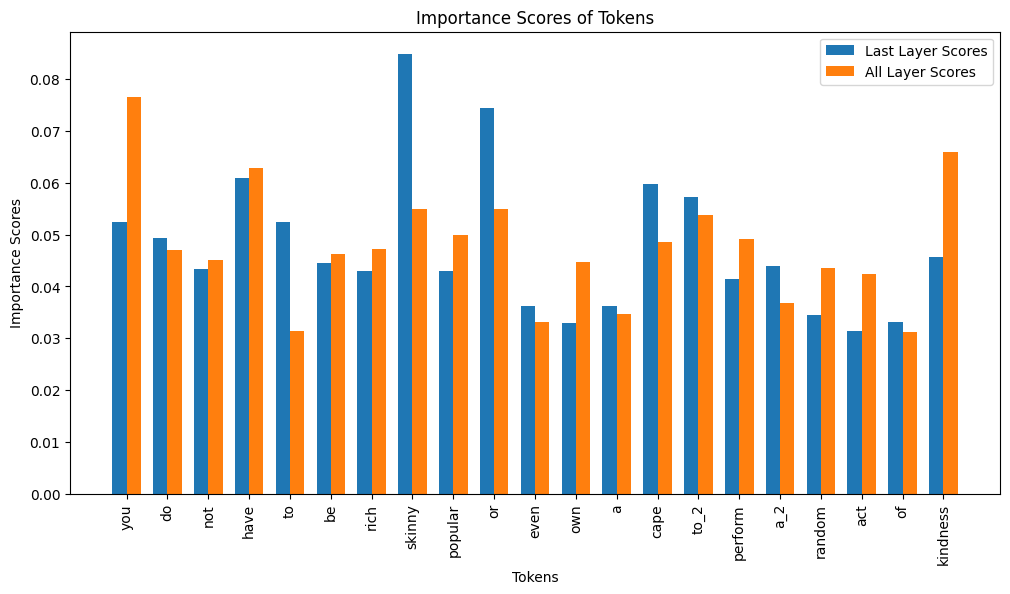

In [5]:
compare_token_importance( 
    tokens, last_layer_importance_probs, all_layer_importance_probs, id="")

#### Create SSML using only the last layer

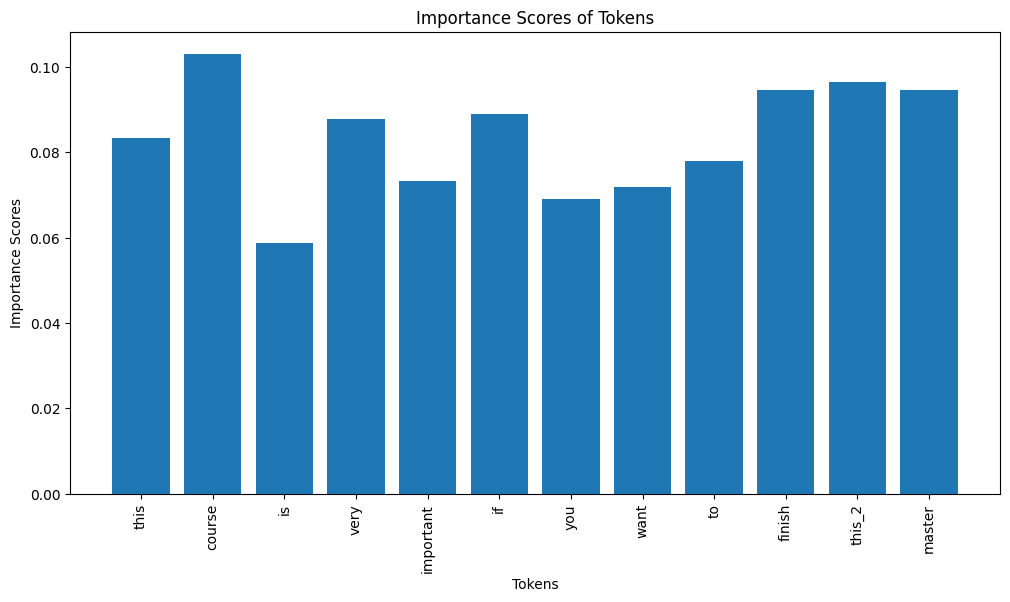

'<speak>this course is very important <prosody pitch="-15%">if you want</prosody> to finish this master </speak>'

In [74]:
dic = return_token_score_dic(tokens, last_layer_importance_probs)

barplot_scores(dic, "last_layer")

generate_ssml(dic,15)

#### Create SSML using only an aggregate of all layer

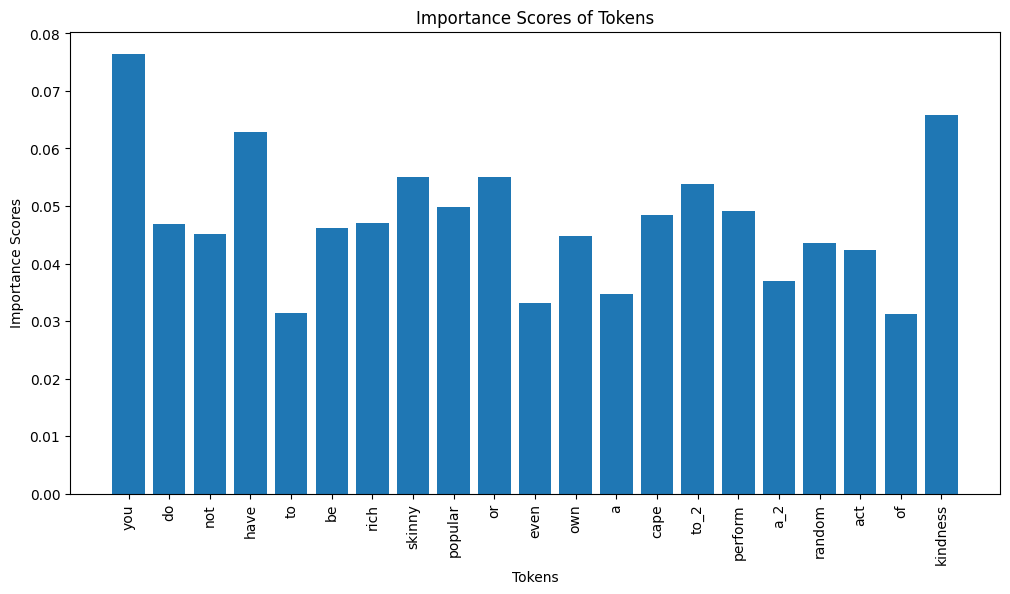

<speak><prosody pitch="+15%">you do not</prosody> have to be rich skinny popular <prosody pitch="-15%">or even own a cape</prosody> to perform a random act of kindness </speak>


In [6]:
dic = return_token_score_dic(tokens, all_layer_importance_probs)

barplot_scores(dic, "all_layers")

ssml = generate_ssml(dic, 15)
print(ssml)


#### Compare Adjusted Audio with original one

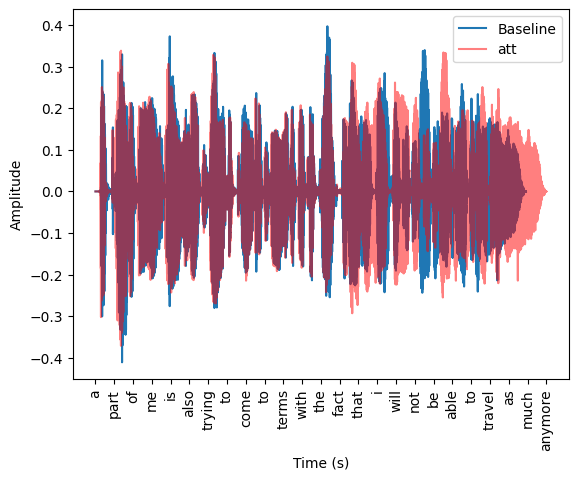

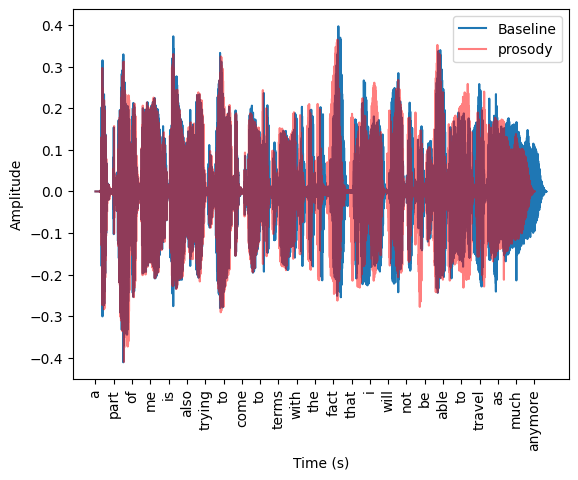

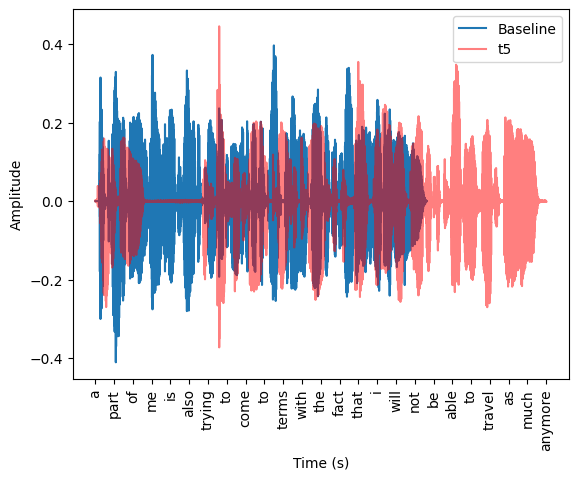

In [7]:
# Define the paths to the WAV files
sound_id_1 = '000377' # I am never more aware..
sound_id_2 = '001202' # you do not have to be rich..
sound_id_3 = '001276' # It was only when..
sound_id_4 = '002279' # We miss you and miss having..
sound_id_5 = '003965' # A part of me

sound = sound_id_5
string = str_5
plot_audios(sound, string, 'attention', 'att')
plot_audios(sound, string, 'prosody', 'prosody')
plot_audios(sound, string, 't5', 't5')


